# GALAH DR3 Tutorial 5: Best RV and Distance

#### Author(s):
Sven Buder (SB, sven.buder@anu.edu.au)

In [39]:
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

import numpy as np
from astropy.table import Table,join
import os
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

## Collecting all relevant catalogs

In [ ]:
catalog_directory = #'../catalogs/'
# Take "#" out with correct directory before running!

In [ ]:
def load_catalog(name='main_allspec_v2',catalog_directory='../catalogs/'):
    try:
        return(Table.read(catalog_directory+'GALAH_DR3_'+name+'.fits'))
    except:
        try:
            os.system('wget https://cloud.datacentral.org.au/teamdata/GALAH/public/GALAH_DR3/GALAH_DR3_'+name+'.fits '+catalog_directory)
        except:
            return(Table.read(catalog_directory+'GALAH_DR3_'+name+'.fits'))

In [ ]:
# Now let's load all catalogs
dr3_main = load_catalog(name='main_allspec_v2')
dr3_ages = load_catalog(name='VAC_ages_v2')
dr3_dynamics = load_catalog(name='VAC_dynamics_v2')
dr3_gaia = load_catalog(name='VAC_GaiaEDR3_v2')
dr3_rv = load_catalog(name='VAC_rv_v2')

In [ ]:
# Now let's join them to a master "dr3" Table
dr3_12 = join(dr3_main,dr3_ages,keys='sobject_id',metadata_conflicts='silent')
dr3_123 = join(dr3_12,dr3_dynamics,keys='sobject_id',metadata_conflicts='silent')
dr3_1234 = join(dr3_123,dr3_gaia,keys='sobject_id',metadata_conflicts='silent')
dr3 = join(dr3_1234,dr3_rv,keys='sobject_id',metadata_conflicts='silent')

# Get a column for the best RV

In [27]:
# Check your science case here! "rv_galah_1" includes gravitational redshift correction where possible!

def get_best_rv(use_graviational_redshift=True):
    """
    Return the best RV and e_RV
    By default, we use graviational redshift corrections, if available.
    This is recommended for accurate measurements, e.g. for Galacitc/stellar dynamics experiments
    
    However, if you want to compare RV changes with respect to other surveys
    (which do not use the gravitational redshift corrections), 
    you want to set use_graviational_redshift = False
    """
    rv = dr3['rv_galah_1']
    e_rv = dr3['e_rv_galah_1']

    # If you rather want the pure measurements
    # (e.g. to compare with other surveys, who did not apply the redshift correction)
    # set use_gravitational_redshift = False
    if not use_graviational_redshift:
        rv[dr3['use_rv_flag_1']==0] = dr3['rv_nogr_obst'][dr3['use_rv_flag_1']==0]
        e_rv[dr3['use_rv_flag_1']==0] = dr3['e_rv_nogr_obst'][dr3['use_rv_flag_1']==0]
        
    # Add Gaia eDR3 measurements if we have no or worse GALAH ones
    rv[dr3['use_rv_flag_1']==2] = dr3['dr2_radial_velocity_1'][dr3['use_rv_flag_1']==2]
    e_rv[dr3['use_rv_flag_1']==2] = dr3['dr2_radial_velocity_error_1'][dr3['use_rv_flag_1']==2]
    
    return(rv,e_rv)

dr3['rv'],dr3['e_rv'] = get_best_rv(use_graviational_redshift=True)
dr3['rv_nogr'],dr3['e_rv_nogr'] = get_best_rv(use_graviational_redshift=False)

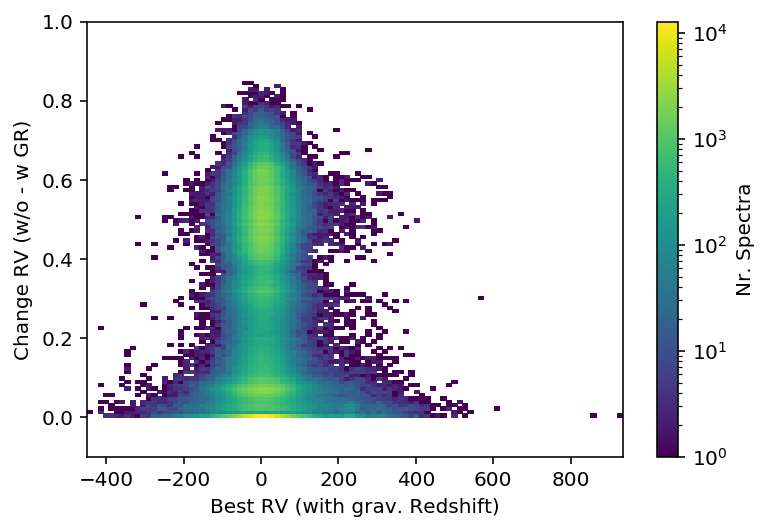

In [41]:
def test_impact_graviational_redshift():
    unflagged = np.isfinite(dr3['rv'])
    p,x,y,s = plt.hist2d(
        dr3['rv'][unflagged],
        dr3['rv_nogr'][unflagged]-dr3['rv'][unflagged],
        cmin=1,bins=100,norm=LogNorm()
    )
    c=plt.colorbar(s)
    c.set_label('Nr. Spectra')
    plt.xlabel('Best RV (with grav. Redshift)')
    plt.ylabel('Change RV (w/o - w GR)')
    plt.ylim(-0.1,1.0)
test_impact_graviational_redshift()

# Get a column for the best Distance

In [ ]:
# Use BSTEP to start with
dr3['distance'] = 1000.*dr3['distance_bstep']
dr3['lo_distance'] = 1000.*(dr3['distance_bstep'] - dr3['e_distance_bstep'])
dr3['hi_distance'] =  1000.*(dr3['distance_bstep'] + dr3['e_distance_bstep'])

# Use Bailer-Jones et al. (2020) photogeometric distances
dr3['distance'][dr3['use_dist_flag']==1] = dr3['r_med_photogeo'][dr3['use_dist_flag']==1]
dr3['lo_distance'][dr3['use_dist_flag']==1] = dr3['r_lo_photogeo'][dr3['use_dist_flag']==1]
dr3['hi_distance'][dr3['use_dist_flag']==1] = dr3['r_hi_photogeo'][dr3['use_dist_flag']==1]

# Use Bailer-Jones et al. (2020) geometric distances
dr3['distance'][dr3['use_dist_flag']==2] = dr3['r_med_geo'][dr3['use_dist_flag']==2]
dr3['lo_distance'][dr3['use_dist_flag']==2] = dr3['r_lo_geo'][dr3['use_dist_flag']==2]
dr3['hi_distance'][dr3['use_dist_flag']==2] = dr3['r_hi_geo'][dr3['use_dist_flag']==2]

# Use 1./parallax
dr3['distance'][dr3['use_dist_flag']==4] = 1./dr3['parallax_corr'][dr3['use_dist_flag']==4]
dr3['lo_distance'][dr3['use_dist_flag']==4] = 1./(dr3['parallax_corr'][dr3['use_dist_flag']==4]+dr3['parallax_error'][dr3['use_dist_flag']==4])
dr3['hi_distance'][dr3['use_dist_flag']==4] = 1./(dr3['parallax_corr'][dr3['use_dist_flag']==4]-dr3['parallax_error'][dr3['use_dist_flag']==4])

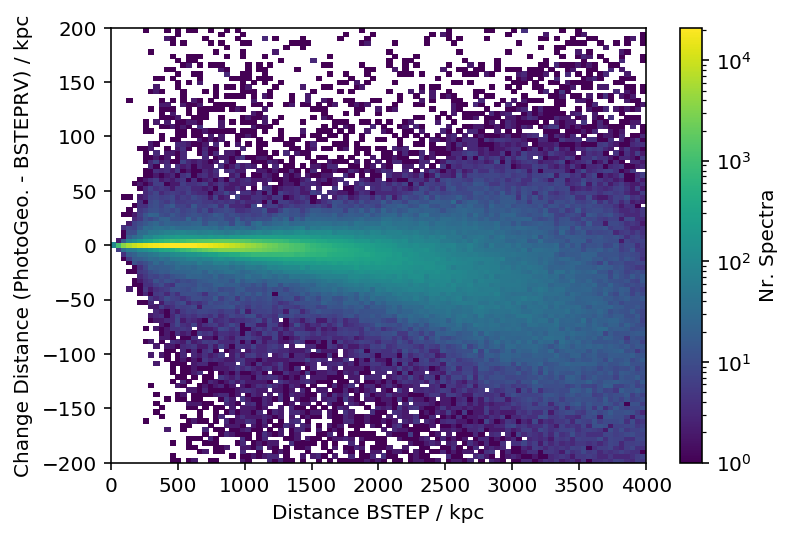

In [48]:
def test_distance_difference():
    unflagged = np.isfinite(dr3['distance_bstep']) & np.isfinite(dr3['r_med_photogeo'])
    p,x,y,s = plt.hist2d(
        1000.*dr3['distance_bstep'][unflagged],
        dr3['r_med_photogeo'][unflagged]-1000.*dr3['distance_bstep'][unflagged],
        cmin=1,bins=(np.linspace(0,4000,100),np.linspace(-200,200,100)),norm=LogNorm()
    )
    c=plt.colorbar(s)
    c.set_label('Nr. Spectra')
    plt.xlabel('Distance BSTEP / kpc')
    plt.ylabel('Change Distance (PhotoGeo. - BSTEPRV) / kpc')
test_distance_difference()